In [1]:
### Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Set plot style
sns.set(style="whitegrid")

### Load the Dataset
df = pd.read_csv("match_data")

# Display the first few rows of the dataset
print("Data Sample:")
print(df.head())



Data Sample:
   fixture_id  halftime         current_time  half_start_datetime  \
0  19172016.0  1st-half  2024-08-09 18:11:36  2024-08-09 18:01:37   
1  19172016.0  1st-half  2024-08-09 18:27:30  2024-08-09 18:01:37   
2  19172016.0  1st-half  2024-08-09 18:28:25  2024-08-09 18:01:37   
3  19172016.0  1st-half  2024-08-09 18:29:32  2024-08-09 18:01:37   
4  19172016.0  1st-half  2024-08-09 18:30:37  2024-08-09 18:01:37   

  match_start_datetime  minute  second latest_bookmaker_update  suspended  \
0  2024-08-09 18:01:37       9      59     2024-08-09 18:11:28      False   
1  2024-08-09 18:01:37      25      53     2024-08-09 18:27:24      False   
2  2024-08-09 18:01:37      26      48     2024-08-09 18:28:20      False   
3  2024-08-09 18:01:37      27      55     2024-08-09 18:29:28      False   
4  2024-08-09 18:01:37      29       0     2024-08-09 18:30:32       True   

   stopped  ...  Throwins - home  Total Crosses - away  Total Crosses - home  \
0    False  ...              

In [2]:
data = df.copy()
len(data)

63944

# Data Cleaning

In [3]:
data = data.sort_values(by=["fixture_id", "current_time"]).reset_index(drop=True)
data.drop_duplicates(subset=["fixture_id", "current_time"], inplace=True)

In [4]:
numeric_cols = ["1", "X", "2"]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors="coerce")
datetime_cols = ["current_time", "half_start_datetime", "latest_bookmaker_update"]
data[datetime_cols] = data[datetime_cols].apply(pd.to_datetime, errors="coerce")

In [5]:

# Columns to forward-fill
cols = ["halftime", "final_score", "half_start_datetime"]

# Forward-fill specific columns within each fixture_id
data[cols] = data.groupby("fixture_id")[cols].apply(lambda x: x.ffill())

/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/594055677.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data[cols] = data.groupby("fixture_id")[cols].apply(lambda x: x.ffill())


In [6]:

def fill_missing_current_time(group):
    prev_current_time = None
    latest_current_time = None
    counter = None

    for idx in range(len(group)):
        if pd.notnull(group.iloc[idx]):
            # Update the latest current time and reset counter
            latest_current_time = group.iloc[idx]
            if counter is not None:
                increment = float(latest_current_time-prev_current_time-1)/float(counter)
                for i in range(1,counter+1):
                    group.iloc[idx-i] = increment*(counter-i+1) + prev_current_time
                counter = None
        else:
            # Increment the counter if current_time is missing
            if counter is None:
                prev_current_time = group.iloc[idx-1]
                counter = 1
            counter += 1
    return group

# Apply the function within each fixture_id
data["current_time"] = data.groupby("fixture_id")["current_time"].transform(
    fill_missing_current_time
)

In [7]:
# Calculate time difference and identify invalid halves based on time_diff
data["threshold_check"] = ((
    data["current_time"] - data["latest_bookmaker_update"]
).dt.total_seconds() / 60) > 20

invalid_time = data.loc[data["threshold_check"] == True, ["fixture_id", "halftime"]].drop_duplicates()

data.drop(columns=["threshold_check"], inplace=True)

In [8]:

# Forward-fill odds columns within each fixture_id with a limit of 10
data[["1", "2", "X"]] = data.groupby("fixture_id")[["1", "2", "X"]].apply(lambda x: x.ffill(limit=10))


/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/585922514.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data[["1", "2", "X"]] = data.groupby("fixture_id")[["1", "2", "X"]].apply(lambda x: x.ffill(limit=10))


In [9]:

# Identify invalid halves due to missing values in critical columns
missing = (
    data.loc[data[["final_score", "halftime", "current_time", "half_start_datetime", "1", "2", "X"]].isna().any(axis=1), ["fixture_id", "halftime"]]
    .drop_duplicates()
)

In [10]:
# Combine invalid halves due to invalid_time and missing values
invalid_halves = pd.concat([invalid_time, missing], ignore_index=True).drop_duplicates()


# Filter out rows corresponding to invalid halves
invalid_set = set(invalid_halves.itertuples(index=False, name=None))

In [11]:
# Use isin to filter rows based on the set of invalid halves
data = data[~data[["fixture_id", "halftime"]].isin(invalid_set).any(axis=1)]


In [12]:
filtered_data = data[(data['suspended'] == False) & (data['stopped'] == False)]

# Task 1

## Draw Matches - Plot Bin

### Task 1.1 & Task 1.2 - Calculate Probabilities

In [13]:
# Probabilities
filtered_data['P_home_win'] = 1 / filtered_data['1']
filtered_data['P_tie'] = 1 / filtered_data['X']
filtered_data['P_away_win'] = 1 / filtered_data['2']
filtered_data["P_home-P_away"] = filtered_data['P_home_win']- filtered_data['P_tie'] 


# Normalize 
total_prob = filtered_data[['P_home_win', 'P_tie', 'P_away_win']].sum(axis=1)
filtered_data['P_home_win_normalized'] = filtered_data['P_home_win'] / total_prob
filtered_data['P_tie_normalized'] = filtered_data['P_tie'] / total_prob
filtered_data['P_away_win_normalized'] = filtered_data['P_away_win'] / total_prob
filtered_data["P_home-P_away_normalized"] = filtered_data['P_home_win_normalized']- filtered_data['P_away_win_normalized'] 


/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/1697231727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['P_home_win'] = 1 / filtered_data['1']
/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/1697231727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['P_tie'] = 1 / filtered_data['X']
/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/1697231727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [14]:
df_first_half=filtered_data.query("halftime=='1st-half'").copy()
df_second_half=filtered_data.query("halftime=='2nd-half'").copy()

### Task 1.3 - Plot

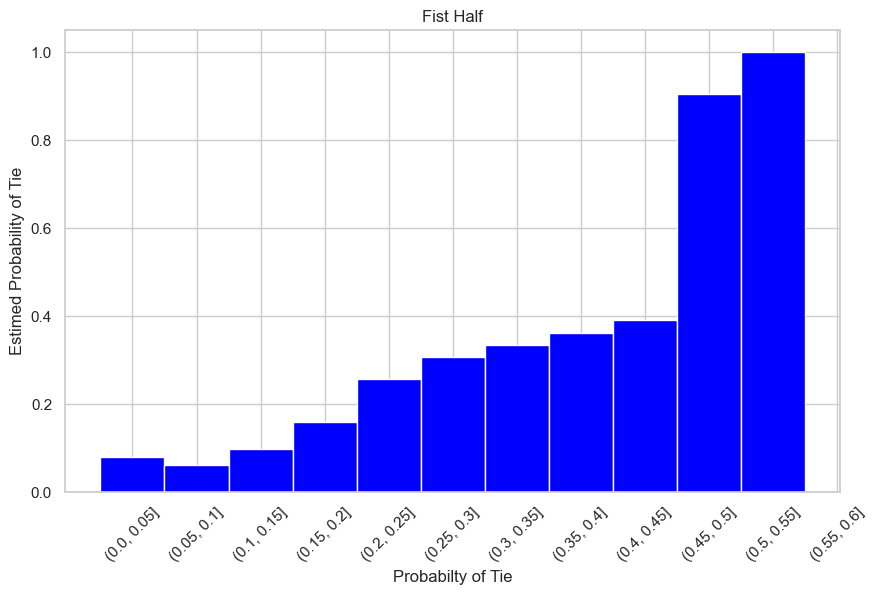

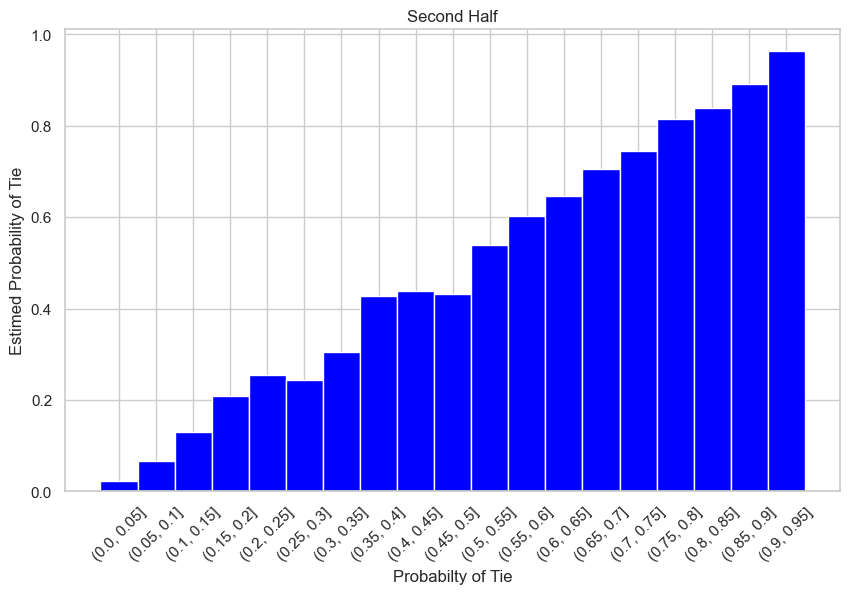

In [15]:
bins = np.arange(0, 1, 0.05) 

df_first_half_draws = df_first_half.copy()
df_second_half_draws = df_second_half.copy()


df_first_half_draws['bin'] = pd.cut(df_first_half_draws["P_tie_normalized"], bins)
draw_counts_first_half = df_first_half_draws.query("result == 'X'").groupby("bin",observed=False).size().reset_index()
counts_first_half = df_first_half_draws.groupby("bin",observed=False).size().reset_index()
draw_counts_first_half["prob"] = draw_counts_first_half[0]/counts_first_half[0]
draw_counts_first_half["bin"] = draw_counts_first_half["bin"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(draw_counts_first_half["bin"], draw_counts_first_half["prob"], width=1, align="center", color="blue")
plt.xlabel("Probabilty of Tie")
plt.ylabel("Estimed Probability of Tie")
plt.xticks(rotation=45)
plt.title("Fist Half")
plt.grid(True)
plt.show()


df_second_half_draws['bin'] = pd.cut(df_second_half_draws["P_tie_normalized"], bins)
draw_counts_second_half = df_second_half_draws.query("result == 'X'").groupby("bin",observed=False).size().reset_index()
counts_second_half = df_second_half_draws.groupby("bin",observed=False).size().reset_index()
draw_counts_second_half["prob"] = draw_counts_second_half[0]/counts_second_half[0]
draw_counts_second_half["bin"] = draw_counts_second_half["bin"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(draw_counts_second_half["bin"], draw_counts_second_half["prob"], width=1, align="center", color="blue")
plt.xlabel("Probabilty of Tie")
plt.ylabel("Estimed Probability of Tie")
plt.xticks(rotation=45)
plt.title("Second Half")
plt.grid(True)
plt.show()


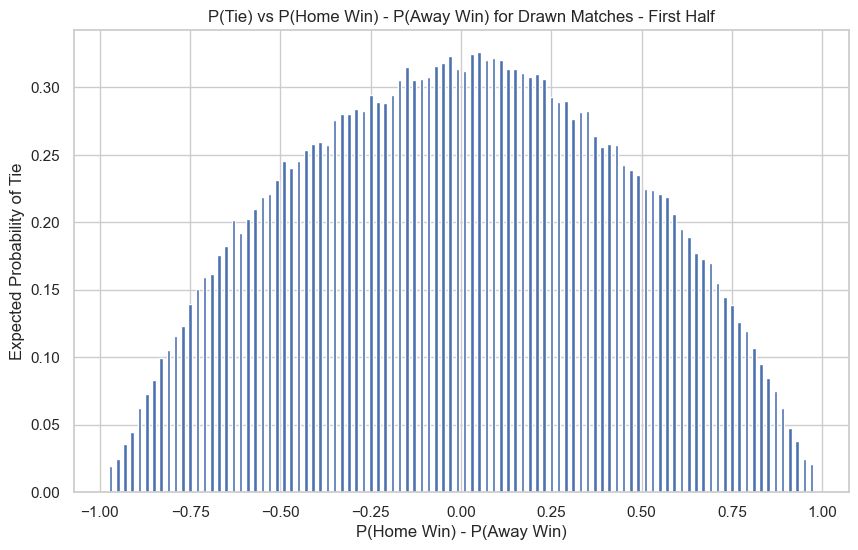

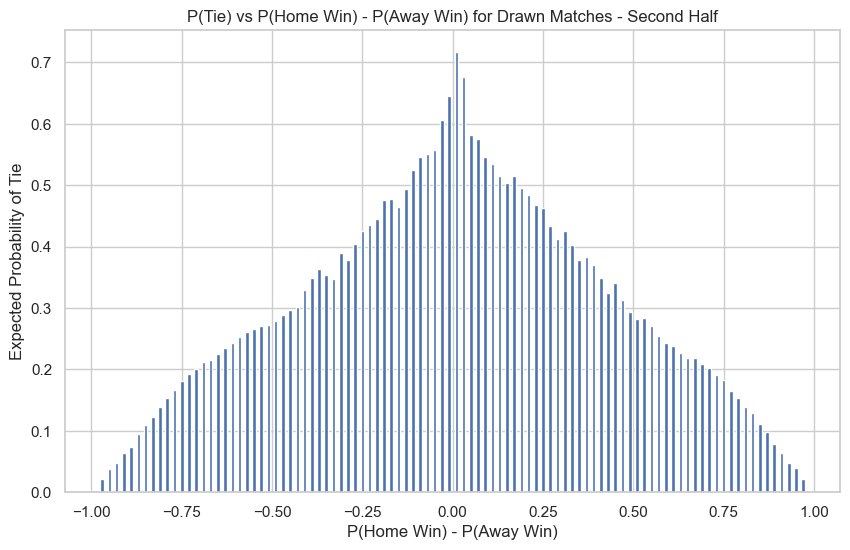

In [16]:
bins = np.arange(-1, 1, 0.02) 

df_first_half_draws = df_first_half_draws.copy()
df_second_half_draws = df_second_half.copy()

df_first_half_draws['bin'] = pd.cut(df_first_half_draws["P_home_win_normalized"] - df_first_half_draws["P_away_win_normalized"], bins)
df_second_half_draws['bin'] = pd.cut(df_second_half_draws["P_home_win_normalized"] - df_second_half_draws["P_away_win_normalized"], bins)

tie_first_half = df_first_half_draws.groupby("bin",observed=False)["P_tie_normalized"].mean()
tie_second_half = df_second_half_draws.groupby("bin",observed=False)["P_tie_normalized"].mean()

plt.figure(figsize=(10, 6))
plt.bar(tie_first_half.index.categories.mid, tie_first_half, width=0.01, align="center")
plt.xlabel("P(Home Win) - P(Away Win)")
plt.ylabel("Expected Probability of Tie")
plt.title("P(Tie) vs P(Home Win) - P(Away Win) for Drawn Matches - First Half")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(tie_second_half.index.categories.mid, tie_second_half, width=0.01, align="center")
plt.xlabel("P(Home Win) - P(Away Win)")
plt.ylabel("Expected Probability of Tie")
plt.title("P(Tie) vs P(Home Win) - P(Away Win) for Drawn Matches - Second Half")
plt.grid(True)
plt.show()

## Home Win - Away Win vs Tie Probabilities 

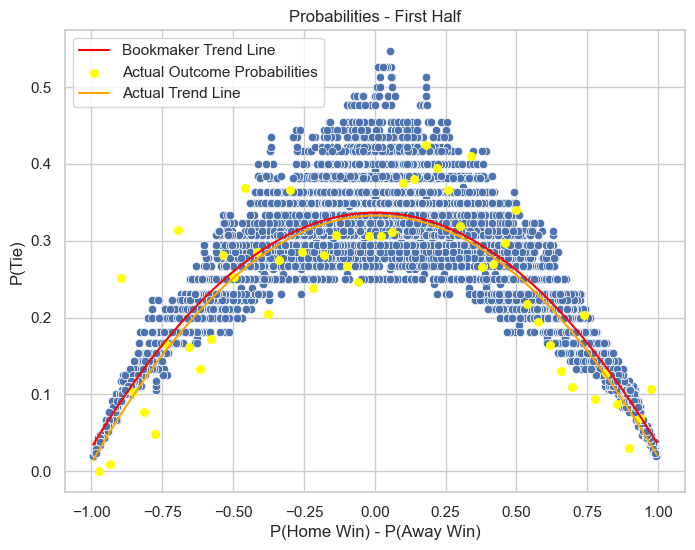

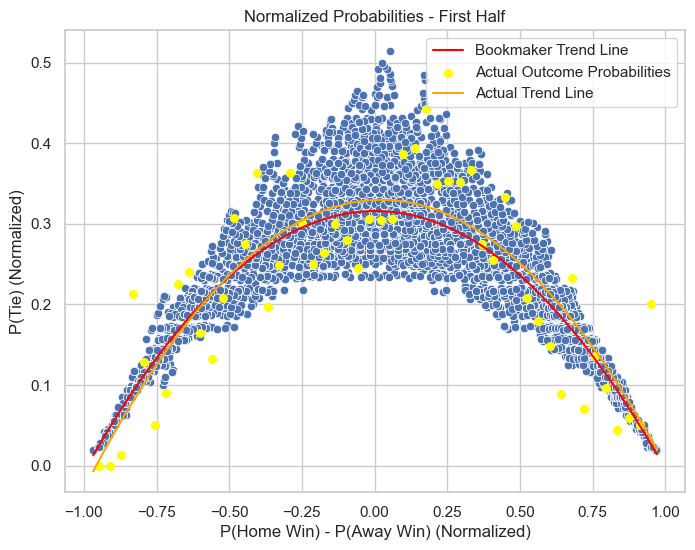

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_first_half['P_home_win'] - df_first_half['P_away_win'], y=df_first_half['P_tie'])
x = df_first_half["P_home_win"] - df_first_half["P_away_win"]
y = df_first_half["P_tie"]
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")


df_first_half["P_home-P_away_bin"] = pd.cut(x, bins=50)
actual = (
    df_first_half.groupby("P_home-P_away_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)
center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")


plt.xlabel('P(Home Win) - P(Away Win)')
plt.ylabel('P(Tie)')
plt.title('Probabilities - First Half')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_first_half['P_home_win_normalized'] - df_first_half['P_away_win_normalized'], y=df_first_half['P_tie_normalized'])
x = df_first_half['P_home_win_normalized'] - df_first_half['P_away_win_normalized']
y = df_first_half['P_tie_normalized']
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")

df_first_half["P_home-P_away_normalized_bin"] = pd.cut(x, bins=50)
actual = (
    df_first_half.groupby("P_home-P_away_normalized_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)

center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")

plt.xlabel('P(Home Win) - P(Away Win) (Normalized)')
plt.ylabel('P(Tie) (Normalized)')
plt.title('Normalized Probabilities - First Half')
plt.legend()
plt.show()



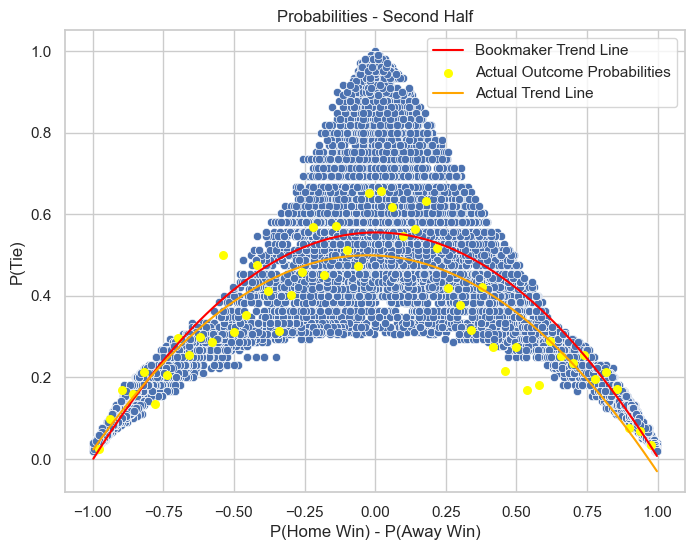

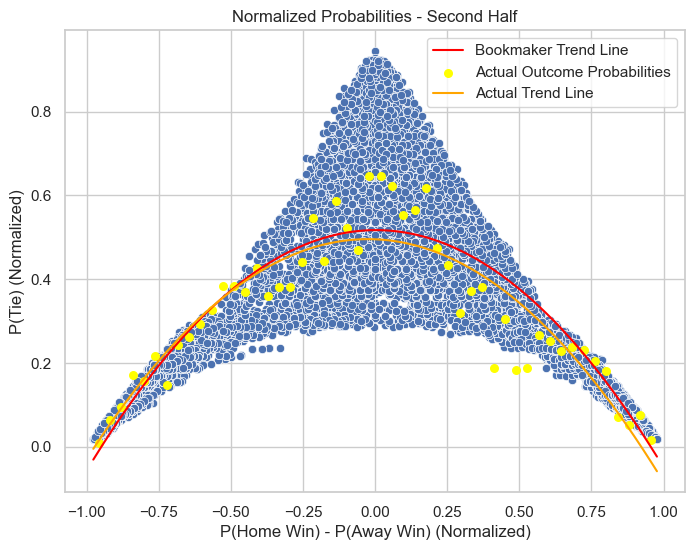

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_second_half['P_home_win'] - df_second_half['P_away_win'], y=df_second_half['P_tie'])
x = df_second_half["P_home_win"] - df_second_half["P_away_win"]
y = df_second_half["P_tie"]
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")


df_second_half["P_home-P_away_bin"] = pd.cut(x, bins=50)
actual = (
    df_second_half.groupby("P_home-P_away_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)
center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")


plt.xlabel('P(Home Win) - P(Away Win)')
plt.ylabel('P(Tie)')
plt.title('Probabilities - Second Half')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_second_half['P_home_win_normalized'] - df_second_half['P_away_win_normalized'], y=df_second_half['P_tie_normalized'])
x = df_second_half['P_home_win_normalized'] - df_second_half['P_away_win_normalized']
y = df_second_half['P_tie_normalized']
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")

df_second_half["P_home-P_away_normalized_bin"] = pd.cut(x, bins=50)
actual = (
    df_second_half.groupby("P_home-P_away_normalized_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)

center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")

plt.xlabel('P(Home Win) - P(Away Win) (Normalized)')
plt.ylabel('P(Tie) (Normalized)')
plt.title('Normalized Probabilities - Second Half')
plt.legend()
plt.show()

# Task 2

## Task 2.1 - Additional Data Cleaning

In [19]:

noisy_matches = data[((data['minute'] > 90) & (data['result'] != data['current_state'])) |
                     (data['minute'] <= 15) & (data['Redcards - away'] > 0) | (data['Redcards - home'] > 0)]

print(f"Number of noisy matches: {noisy_matches['fixture_id'].nunique()}")

new_filtered_data = filtered_data[~filtered_data['fixture_id'].isin(noisy_matches['fixture_id'])]

Number of noisy matches: 82


## Task 2.2 - Execution

In [20]:
df_first_half_v2=new_filtered_data.query("halftime=='1st-half'").copy()
df_second_half_v2=new_filtered_data.query("halftime=='2nd-half'").copy()

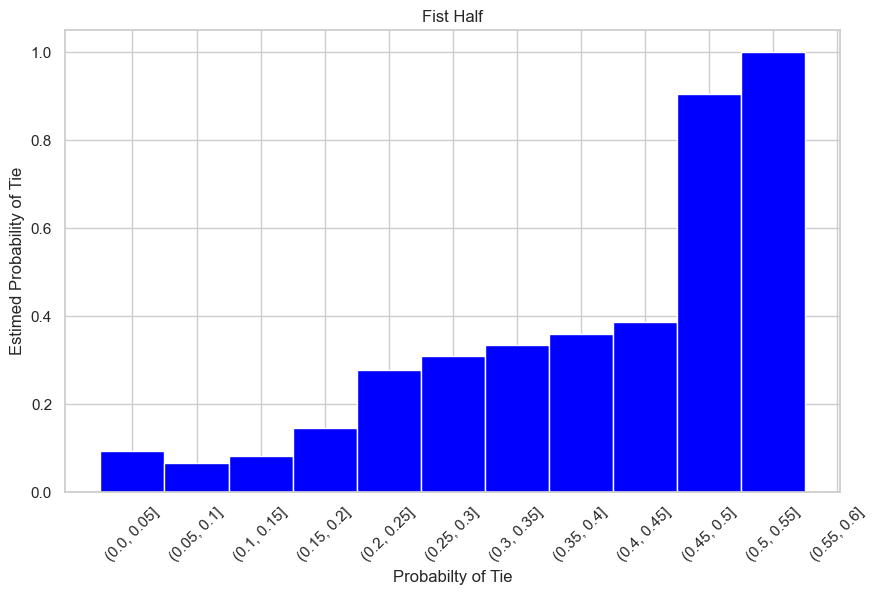

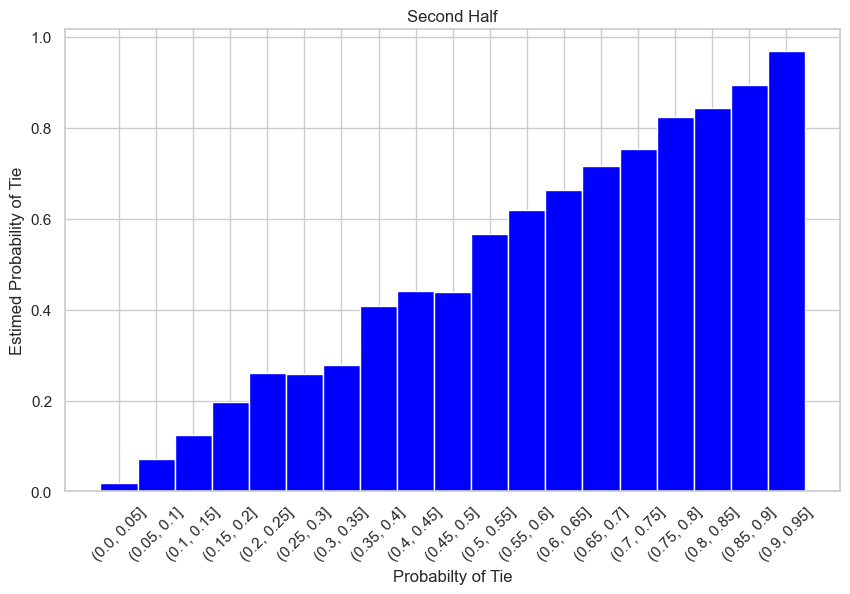

In [21]:
bins = np.arange(0, 1, 0.05) 

df_first_half_draws = df_first_half_v2.copy()
df_second_half_draws = df_second_half_v2.copy()


df_first_half_draws['bin'] = pd.cut(df_first_half_draws["P_tie_normalized"], bins)
draw_counts_first_half = df_first_half_draws.query("result == 'X'").groupby("bin",observed=False).size().reset_index()
counts_first_half = df_first_half_draws.groupby("bin",observed=False).size().reset_index()
draw_counts_first_half["prob"] = draw_counts_first_half[0]/counts_first_half[0]
draw_counts_first_half["bin"] = draw_counts_first_half["bin"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(draw_counts_first_half["bin"], draw_counts_first_half["prob"], width=1, align="center", color="blue")
plt.xlabel("Probabilty of Tie")
plt.ylabel("Estimed Probability of Tie")
plt.xticks(rotation=45)
plt.title("Fist Half")
plt.grid(True)
plt.show()


df_second_half_draws['bin'] = pd.cut(df_second_half_draws["P_tie_normalized"], bins)
draw_counts_second_half = df_second_half_draws.query("result == 'X'").groupby("bin",observed=False).size().reset_index()
counts_second_half = df_second_half_draws.groupby("bin",observed=False).size().reset_index()
draw_counts_second_half["prob"] = draw_counts_second_half[0]/counts_second_half[0]
draw_counts_second_half["bin"] = draw_counts_second_half["bin"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(draw_counts_second_half["bin"], draw_counts_second_half["prob"], width=1, align="center", color="blue")
plt.xlabel("Probabilty of Tie")
plt.ylabel("Estimed Probability of Tie")
plt.xticks(rotation=45)
plt.title("Second Half")
plt.grid(True)
plt.show()


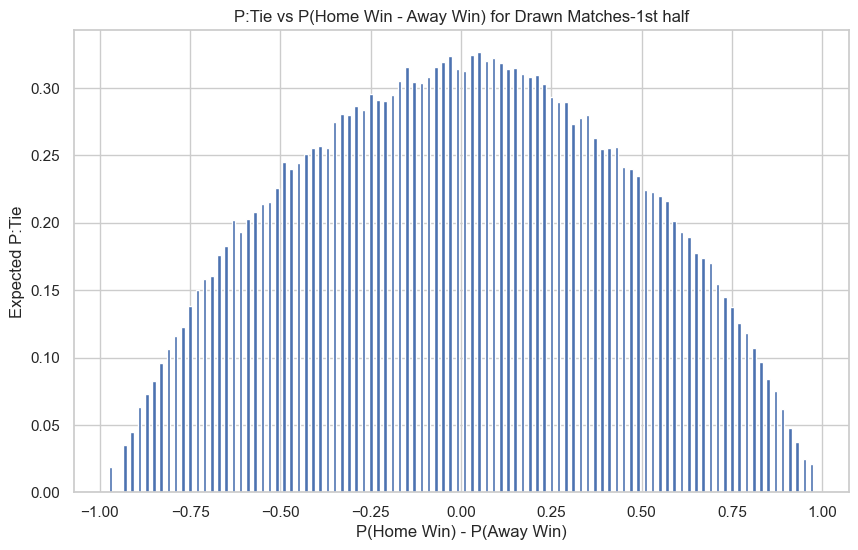

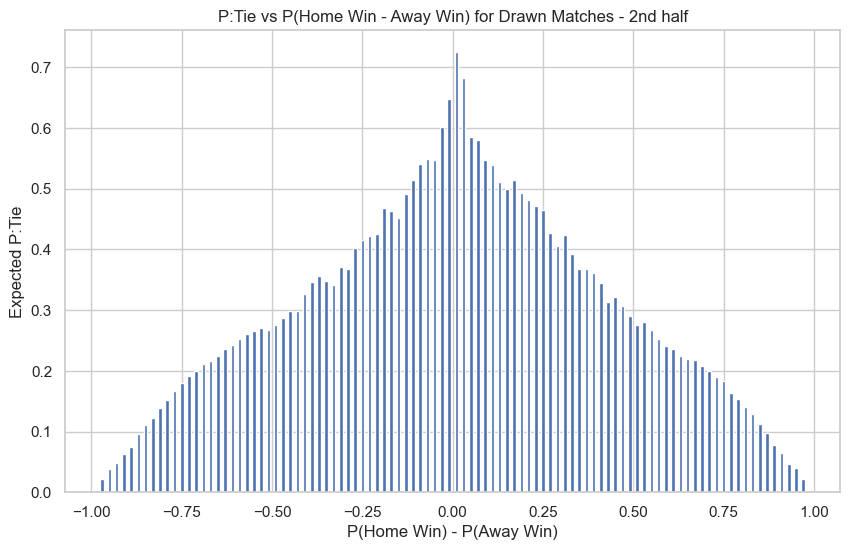

In [22]:

bins = np.arange(-1, 1, 0.02) 


df_first_half_draws_v2 = df_first_half_v2.copy()
df_second_half_draws_v2 = df_second_half_v2.copy()

df_first_half_draws_v2['bin'] = pd.cut(df_first_half_draws_v2["P_home_win_normalized"] - df_first_half_draws_v2["P_away_win_normalized"], bins)
df_second_half_draws_v2['bin'] = pd.cut(df_second_half_draws_v2["P_home_win_normalized"] - df_second_half_draws_v2["P_away_win_normalized"], bins)

tie_first_half_v2 = df_first_half_draws_v2.groupby("bin",observed=False)["P_tie_normalized"].mean()
tie_second_half_v2 = df_second_half_draws_v2.groupby("bin",observed=False)["P_tie_normalized"].mean()


plt.figure(figsize=(10, 6))
plt.bar(tie_first_half_v2.index.categories.mid, tie_first_half_v2, width=0.01, align="center")
plt.xlabel("P(Home Win) - P(Away Win)")
plt.ylabel("Expected P:Tie")
plt.title("P:Tie vs P(Home Win - Away Win) for Drawn Matches-1st half")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(tie_second_half_v2.index.categories.mid, tie_second_half_v2, width=0.01, align="center")
plt.xlabel("P(Home Win) - P(Away Win)")
plt.ylabel("Expected P:Tie")
plt.title("P:Tie vs P(Home Win - Away Win) for Drawn Matches - 2nd half")
plt.grid(True)
plt.show()

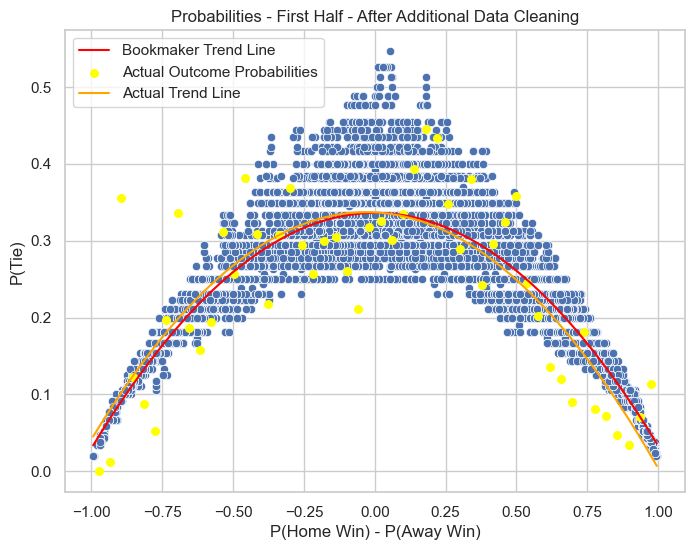

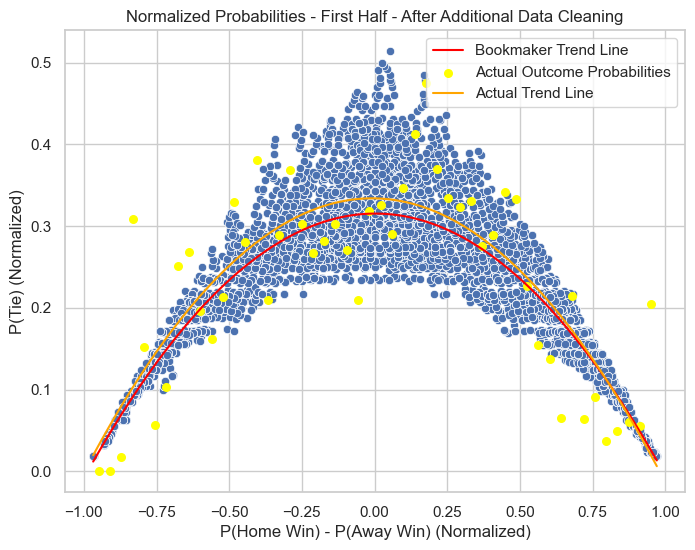

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_first_half_v2['P_home_win'] - df_first_half_v2['P_away_win'], y=df_first_half_v2['P_tie'])
x = df_first_half_v2["P_home_win"] - df_first_half_v2["P_away_win"]
y = df_first_half_v2["P_tie"]
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")


df_first_half_v2["P_home-P_away_bin"] = pd.cut(x, bins=50)
actual = (
    df_first_half_v2.groupby("P_home-P_away_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)
center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")


plt.xlabel('P(Home Win) - P(Away Win)')
plt.ylabel('P(Tie)')
plt.title('Probabilities - First Half - After Additional Data Cleaning')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_first_half_v2['P_home_win_normalized'] - df_first_half_v2['P_away_win_normalized'], y=df_first_half_v2['P_tie_normalized'])
x = df_first_half_v2['P_home_win_normalized'] - df_first_half_v2['P_away_win_normalized']
y = df_first_half_v2['P_tie_normalized']
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")

df_first_half_v2["P_home-P_away_normalized_bin"] = pd.cut(x, bins=50)
actual = (
    df_first_half_v2.groupby("P_home-P_away_normalized_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)

center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")

plt.xlabel('P(Home Win) - P(Away Win) (Normalized)')
plt.ylabel('P(Tie) (Normalized)')
plt.title('Normalized Probabilities - First Half - After Additional Data Cleaning')
plt.legend()
plt.show()



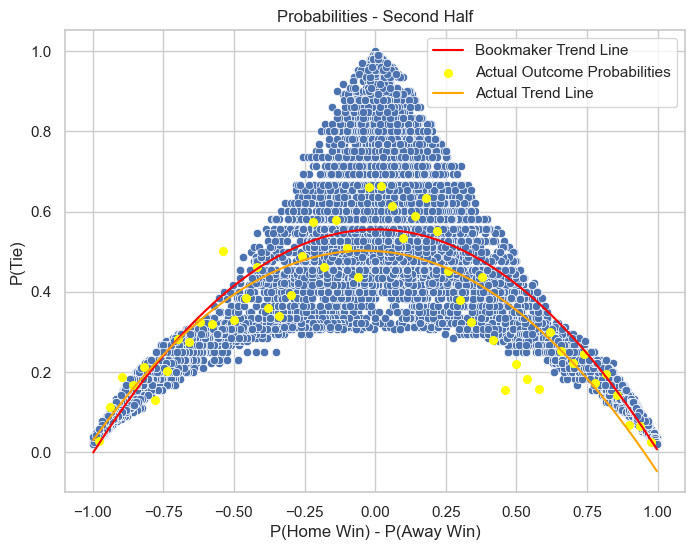

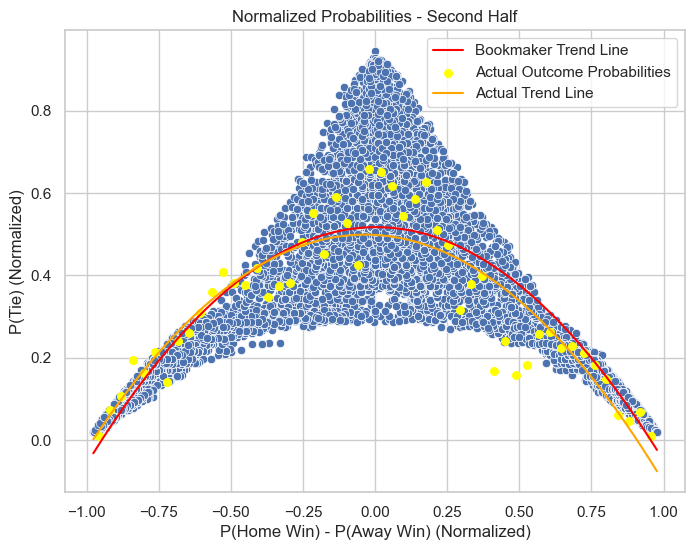

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_second_half_v2['P_home_win'] - df_second_half_v2['P_away_win'], y=df_second_half_v2['P_tie'])
x = df_second_half_v2["P_home_win"] - df_second_half_v2["P_away_win"]
y = df_second_half_v2["P_tie"]
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")


df_second_half_v2["P_home-P_away_bin"] = pd.cut(x, bins=50)
actual = (
    df_second_half_v2.groupby("P_home-P_away_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)
center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")


plt.xlabel('P(Home Win) - P(Away Win)')
plt.ylabel('P(Tie)')
plt.title('Probabilities - Second Half')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_second_half_v2['P_home_win_normalized'] - df_second_half_v2['P_away_win_normalized'], y=df_second_half_v2['P_tie_normalized'])
x = df_second_half_v2['P_home_win_normalized'] - df_second_half_v2['P_away_win_normalized']
y = df_second_half_v2['P_tie_normalized']
coeffs = np.polyfit(x, y, deg=2)
poly = np.poly1d(coeffs)
x_range = np.linspace(x.min(), x.max(), 500)
y_fit = poly(x_range)
plt.plot(x_range, y_fit, color="red", label="Bookmaker Trend Line")

df_second_half_v2["P_home-P_away_normalized_bin"] = pd.cut(x, bins=50)
actual = (
    df_second_half_v2.groupby("P_home-P_away_normalized_bin")["result"]
    .agg(lambda x: (x == "X").sum() / len(x))  # Proportion of games ending in a draw
)

center = actual.index.categories.mid
plt.scatter(center, actual, color="yellow", s=30, label="Actual Outcome Probabilities")

coeffs = np.polyfit(center, actual, deg=2)
poly = np.poly1d(coeffs)
fit = poly(x_range)
plt.plot(x_range, fit, color="orange", label="Actual Trend Line")

plt.xlabel('P(Home Win) - P(Away Win) (Normalized)')
plt.ylabel('P(Tie) (Normalized)')
plt.title('Normalized Probabilities - Second Half')
plt.legend()
plt.show()

# Task 3

/var/folders/xn/471fp4yx36q3xc6lj7h6m2hh0000gn/T/ipykernel_74466/1191215682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_filtered_data["halftime"] = new_filtered_data["halftime"].replace({


Shape of x: (49088, 96)
Shape of y: (49088,)
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.86      0.74      4282
           2       0.66      0.63      0.64      2777
           X       0.50      0.26      0.34      2759

    accuracy                           0.63      9818
   macro avg       0.60      0.58      0.58      9818
weighted avg       0.61      0.63      0.60      9818

Accuracy: 0.63


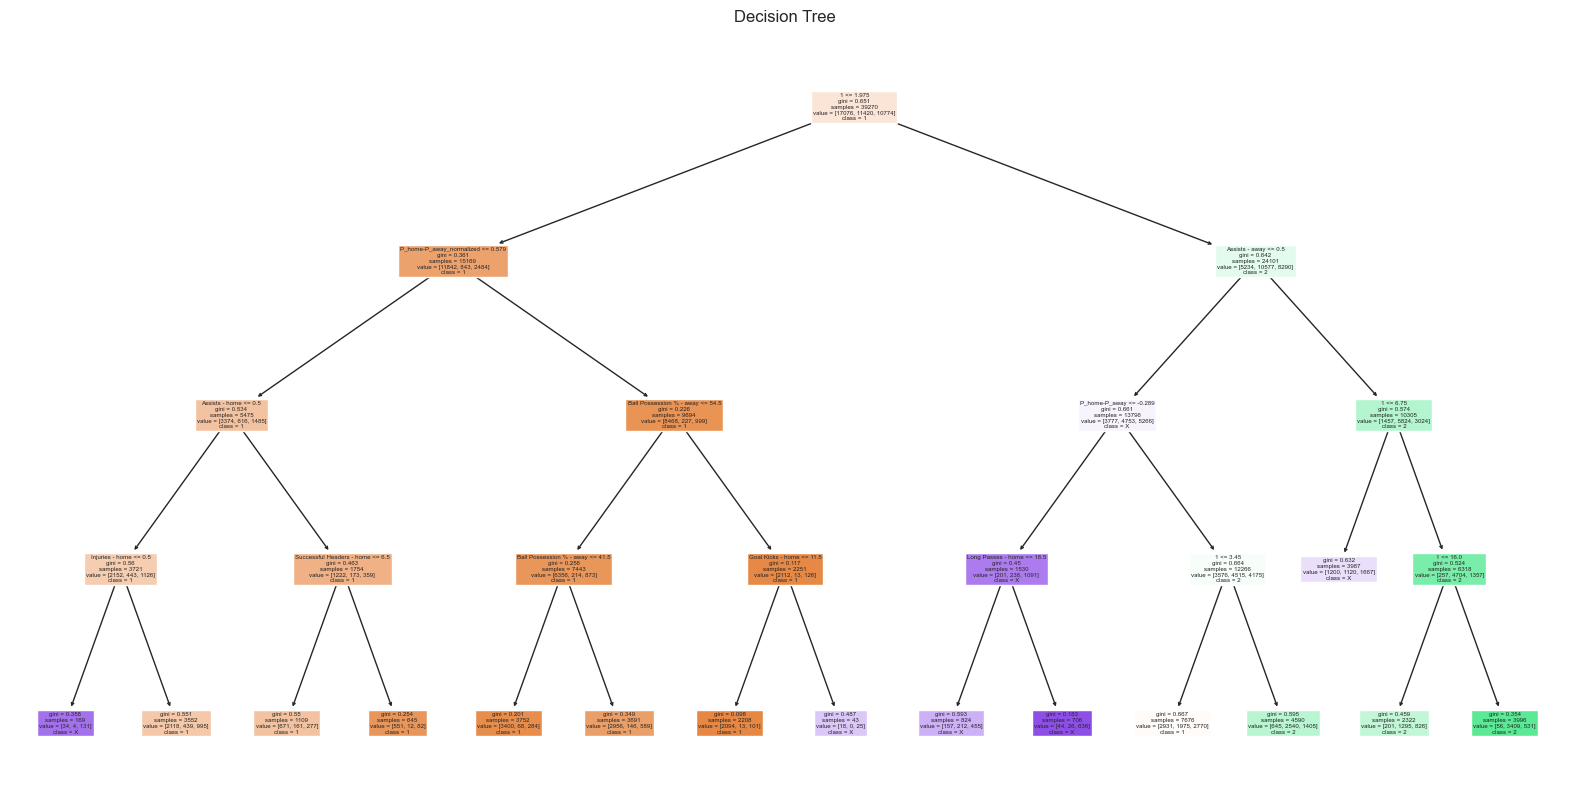

Feature Importance:
                     Feature  Importance
3                          1    0.830211
8             Assists - away    0.062083
95  P_home-P_away_normalized    0.050965
94             P_home-P_away    0.040578
47        Long Passes - home    0.010091
..                       ...         ...
30      Goal Attempts - away    0.000000
29         Free Kicks - home    0.000000
28         Free Kicks - away    0.000000
48           Offsides - away    0.000000
12  Ball Possession % - away   -0.016242

[96 rows x 2 columns]


In [25]:
new_filtered_data["halftime"] = new_filtered_data["halftime"].replace({
    "1st-half": 1,
    "2nd-half": 2
})
numerical_columns = new_filtered_data.select_dtypes(include=[np.number]).columns
tree_columns = [col for col in numerical_columns if col not in ['fixture_id','P_home_win', 'P_tie', 'P_away_win',
       'P_home_win_normalized', 'P_tie_normalized', 'P_away_win_normalized','final_score','result']]
x = new_filtered_data[tree_columns]
y = new_filtered_data["result"]

print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42, max_depth=4,max_features=20,min_samples_leaf=2)

clf.fit(x_train, y_train)
feature_importances = clf.feature_importances_

y_pred = clf.predict(x_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["1", "2", "X"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=list(x.columns), class_names=list(clf.classes_), filled=True)
plt.title("Decision Tree")
plt.savefig("tree.pdf")
plt.show()

importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(importance_df)

In [26]:

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required in a leaf node
    'criterion': ['gini', 'entropy'],  # Split criteria
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the Grid Search to the data
grid_search.fit(x_train, y_train)

# Best parameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Weighted F1 Score: {best_score:.4f}")

# Use the best model to predict on the test set
best_model_v1 = grid_search.best_estimator_
y_pred = best_model_v1.predict(x_test)

# Evaluate the tuned model
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Weighted F1 Score: 0.8532

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.94      0.85      4282
           2       0.92      0.83      0.87      2777
           X       0.83      0.63      0.72      2759

    accuracy                           0.82      9818
   macro avg       0.84      0.80      0.81      9818
weighted avg       0.83      0.82      0.82      9818



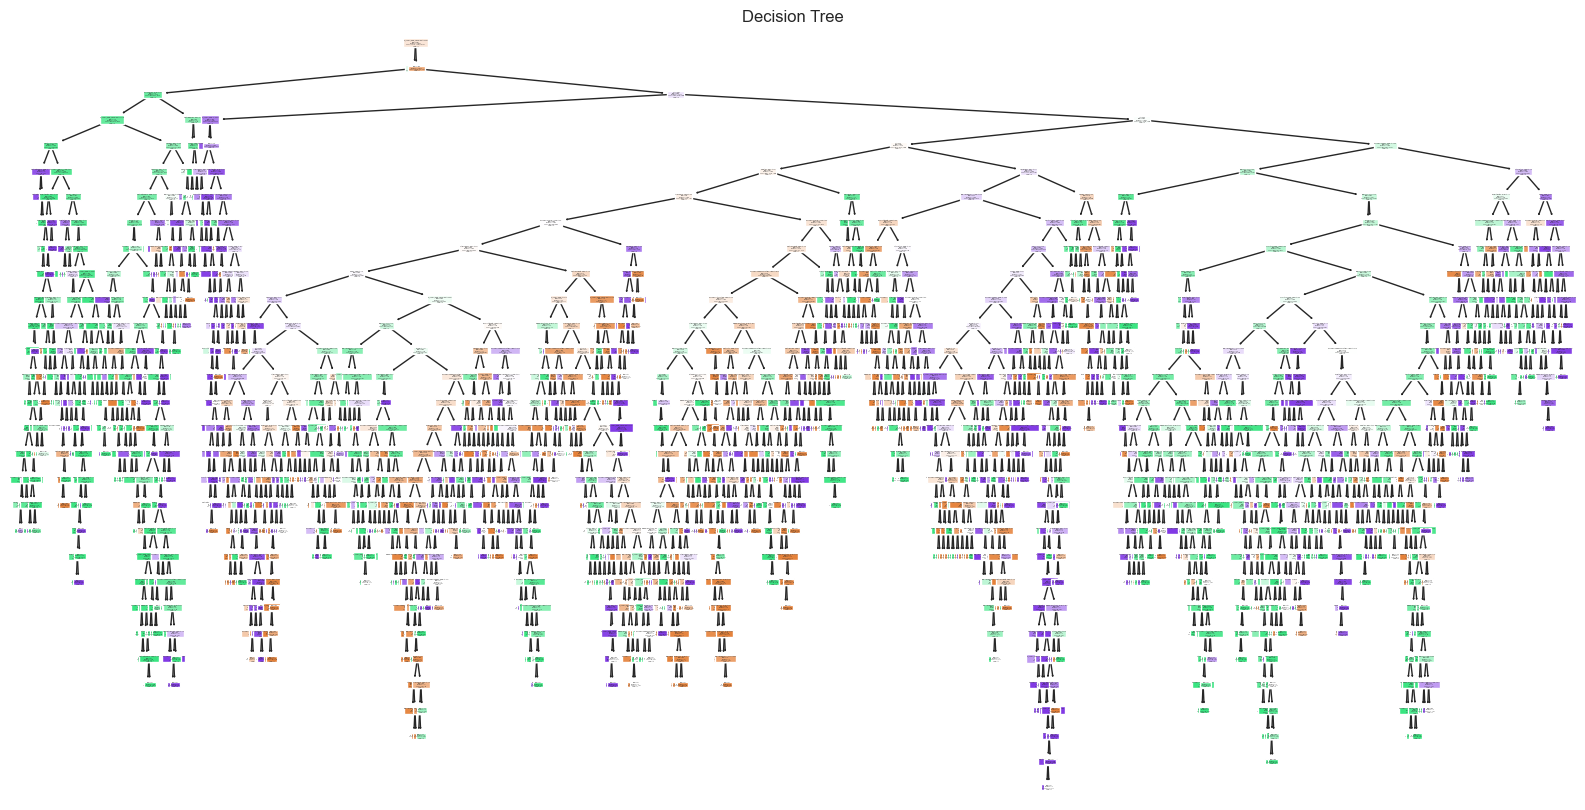

Feature Importance:
                            Feature  Importance
78  Successful Interceptions - away    0.008571
28                Free Kicks - away    0.005791
31             Goal Attempts - home    0.003928
30             Goal Attempts - away    0.003351
8                    Assists - away    0.001614
..                              ...         ...
90               Yellowcards - away         NaN
91               Yellowcards - home         NaN
92           Yellowred Cards - away         NaN
94                    P_home-P_away         NaN
95         P_home-P_away_normalized         NaN

[96 rows x 2 columns]


In [27]:
feature_importances = best_model_v1.feature_importances_

plt.figure(figsize=(20, 10))
plot_tree(best_model_v1, feature_names=list(x.columns), class_names=list(best_model_v1.classes_), filled=True)
plt.title("Decision Tree")
plt.savefig("tree_v1.pdf")
plt.show()

importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(importance_df)

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required in a leaf node
    'criterion': ['gini', 'entropy'],  # Split criteria
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the Grid Search to the data
grid_search.fit(x_train, y_train)

# Best parameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Weighted F1 Score: {best_score:.4f}")

# Use the best model to predict on the test set
best_model_v2 = grid_search.best_estimator_
y_pred = best_model_v2.predict(x_test)

# Evaluate the tuned model
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Weighted F1 Score: 0.8435

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.92      0.83      4282
           2       0.81      0.82      0.82      2777
           X       0.86      0.54      0.66      2759

    accuracy                           0.79      9818
   macro avg       0.81      0.76      0.77      9818
weighted avg       0.80      0.79      0.78      9818



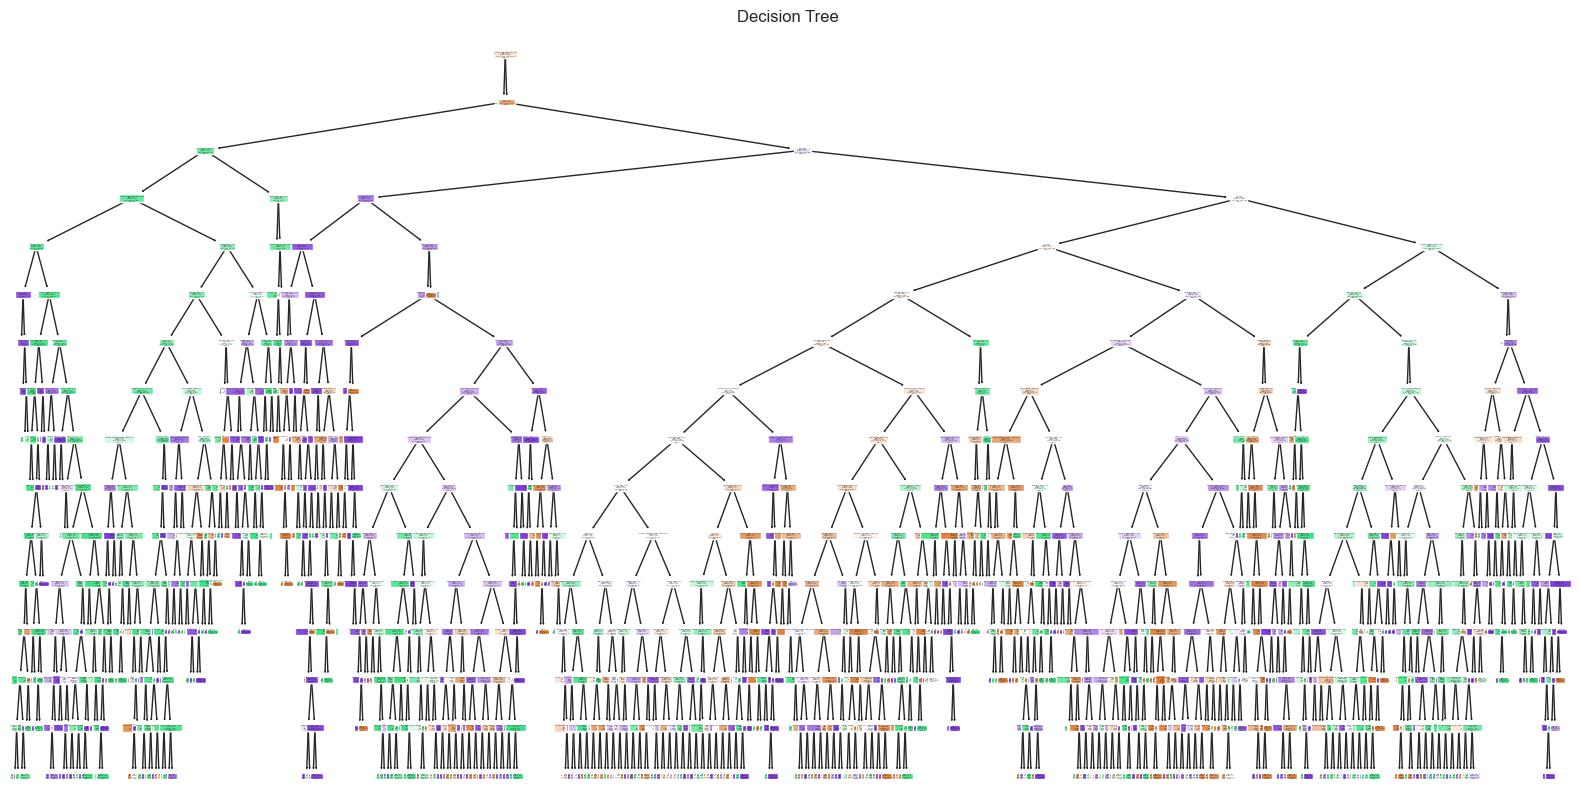

Feature Importance:
                     Feature  Importance
5                          X    0.013850
15          Ball Safe - home    0.004799
28         Free Kicks - away    0.004714
21    Counter Attacks - home    0.003845
48           Offsides - away    0.003785
..                       ...         ...
87           Throwins - home         NaN
89      Total Crosses - home         NaN
90        Yellowcards - away         NaN
94             P_home-P_away         NaN
95  P_home-P_away_normalized         NaN

[96 rows x 2 columns]


In [29]:
feature_importances = best_model_v2.feature_importances_

plt.figure(figsize=(20, 10))
plot_tree(best_model_v2, feature_names=list(x.columns), class_names=list(best_model_v2.classes_), filled=True)
plt.title("Decision Tree")
plt.savefig("tree_v2.pdf")
plt.show()

importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(importance_df)

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required in a leaf node
    'criterion': ['gini', 'entropy'],  # Split criteria
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the Grid Search to the data
grid_search.fit(x_train, y_train)

# Best parameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Weighted F1 Score: {best_score:.4f}")

# Use the best model to predict on the test set
best_model_v3 = grid_search.best_estimator_
y_pred = best_model_v3.predict(x_test)

# Evaluate the tuned model
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Weighted F1 Score: 0.7424

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.82      0.84      4282
           2       0.74      0.78      0.76      2777
           X       0.71      0.70      0.70      2759

    accuracy                           0.78      9818
   macro avg       0.76      0.77      0.76      9818
weighted avg       0.78      0.78      0.78      9818



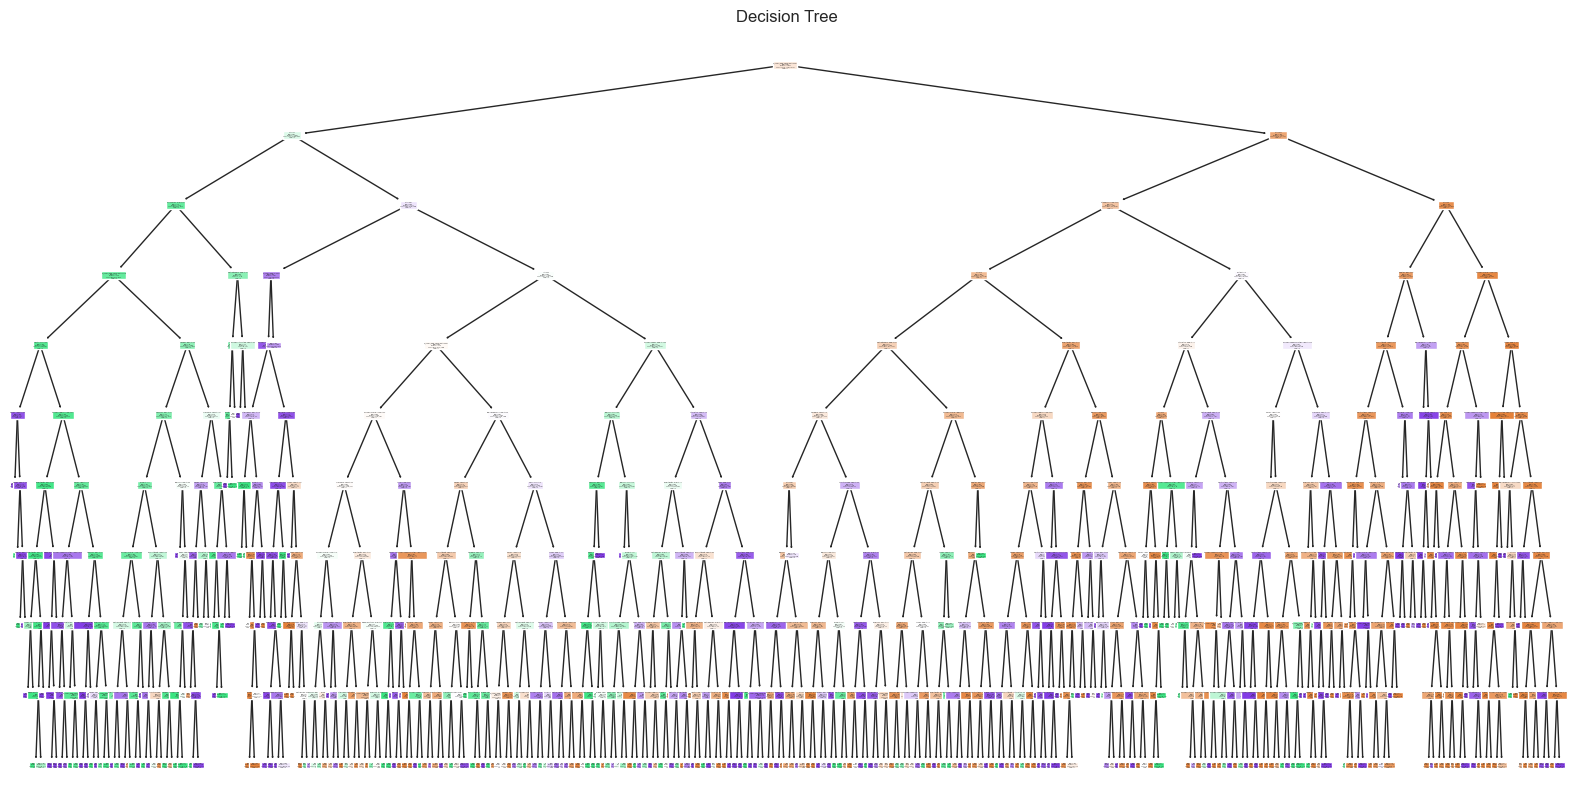

Feature Importance:
                       Feature  Importance
95    P_home-P_away_normalized    0.121398
15            Ball Safe - home    0.008081
30        Goal Attempts - away    0.006547
74  Successful Dribbles - away    0.005938
14            Ball Safe - away    0.005855
..                         ...         ...
85              Tackles - home         NaN
87             Throwins - home         NaN
88        Total Crosses - away         NaN
90          Yellowcards - away         NaN
91          Yellowcards - home         NaN

[96 rows x 2 columns]


In [31]:

feature_importances = best_model_v3.feature_importances_

plt.figure(figsize=(20, 10))
plot_tree(best_model_v3, feature_names=list(x.columns), class_names=list(best_model_v3.classes_), filled=True)
plt.title("Decision Tree")
plt.savefig("tree_v3.pdf")
plt.show()

importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(importance_df)